# Importing libraries

In [138]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

## Importing files

In [139]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

## Understand the table structure

### Train file

In [140]:
train.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you we find the following fields:

1. Store - the store number
2. Dept - the department number
3. Date - the week
4. Weekly_Sales -  sales for the given department in the given store
5. IsHoliday - whether the week is a special holiday week

### Test file

In [142]:
test.head()

Store  Dept       Date  IsHoliday
0      1     1 2012-11-02      False
1      1     1 2012-11-09      False
2      1     1 2012-11-16      False
3      1     1 2012-11-23       True
4      1     1 2012-11-30      False

This file is similar to the train file except that it does not contain the Weekly sales column

## Features file

In [143]:
features.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN  211.350143         8.106      False

In [144]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null datetime64[ns]
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 711.9 KB


This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

1. Store - the store number
2. Date - the week
3. Temperature - average temperature in the region
4. Fuel_Price - cost of fuel in the region
5. MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
6. CPI - the consumer price index
7. Unemployment - the unemployment rate
8. IsHoliday - whether the week is a special holiday week

### Stores file

In [145]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [146]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


This file contains information about the 45 stores, indicating the type and size of store.

# Some sanity checks on the data

Checking to see if the train features and the stores files contains information on all the stores that are present in the train data

In [147]:
np.all(train.Store.unique() == features.Store.unique())


True

In [148]:
np.all(train.Store.unique() == stores.Store.unique())

True

Checking to see if the features data consists of all dates that are in the test and train data

In [149]:
train_date_counts = train.Date.value_counts().reset_index()
test_date_counts = test.Date.value_counts().reset_index()
features_date_counts = features.Date.value_counts().reset_index()
date_counts_df = features_date_counts.merge(train_date_counts,how='outer',on='index').merge(test_date_counts,how='outer',on='index')

In [150]:
date_counts_df.columns = ['Date','Features_count','Train_count','Test_count']

In [151]:
date_counts_df.set_index('Date',inplace=True)

In [152]:
from matplotlib.dates import DateFormatter
myFmt = DateFormatter('%m%y')

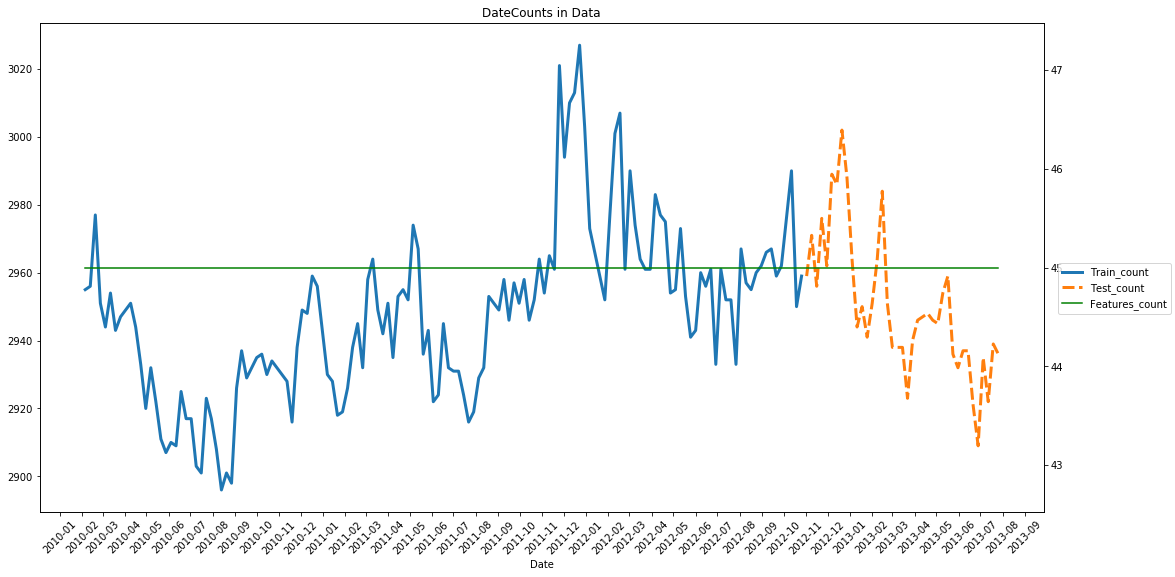

In [153]:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
ax.set_title('DateCounts in Data')
sns.lineplot(data=date_counts_df[['Train_count','Test_count']],linewidth=3,legend=None,ax=ax)
ax2=plt.twinx()
sns.lineplot(data=date_counts_df['Features_count'],color='green',legend=None, ax=ax2,label='Feature_count')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.legend(labels = ('Train_count','Test_count','Features_count'), loc='center right', fancybox=True)
plt.show()

**The features file contains all dates from Jan 2010 till Sep 2013
Test data is for dates between Oct 2012 till Sep 2013
Train data set is between Jan 2010 till Oct 2012**

We see a cyclic trend in the weekly sales (where the peaks are). There is also a seasonal trend and an outlier period where the Counts are very high. This needs to investigated further

## Joining the Stores and features files to train and test data.

In [154]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])

In [155]:
train_data.shape

(421570, 16)

In [156]:
train_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1 2010-02-05      24924.50      False    A  151315        42.31   
1      1     1 2010-02-12      46039.49       True    A  151315        38.51   
2      1     1 2010-02-19      41595.55      False    A  151315        39.93   
3      1     1 2010-02-26      19403.54      False    A  151315        46.63   
4      1     1 2010-03-05      21827.90      False    A  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [157]:
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

In [158]:
test_data.head()

Store  Dept       Date  IsHoliday Type    Size  Temperature  Fuel_Price  \
0      1     1 2012-11-02      False    A  151315        55.32       3.386   
1      1     1 2012-11-09      False    A  151315        61.24       3.314   
2      1     1 2012-11-16      False    A  151315        52.92       3.252   
3      1     1 2012-11-23       True    A  151315        56.23       3.211   
4      1     1 2012-11-30      False    A  151315        52.34       3.207   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0    6766.44    5147.70      50.82    3639.90    2737.42  223.462779   
1   11421.32    3370.89      40.28    4646.79    6154.16  223.481307   
2    9696.28     292.10     103.78    1133.15    6612.69  223.512911   
3     883.59       4.17   74910.32     209.91     303.32  223.561947   
4    2460.03        NaN    3838.35     150.57    6966.34  223.610984   

   Unemployment  
0         6.573  
1         6.573  
2         6.573  
3         6.573  
4         6.573

In [159]:
train_data.describe()

Store           Dept   Weekly_Sales           Size  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123  136727.915739   
std        12.785297      30.492054   22711.183519   60980.583328   
min         1.000000       1.000000   -4988.940000   34875.000000   
25%        11.000000      18.000000    2079.650000   93638.000000   
50%        22.000000      37.000000    7612.030000  140167.000000   
75%        33.000000      74.000000   20205.852500  202505.000000   
max        45.000000      99.000000  693099.360000  219622.000000   

         Temperature     Fuel_Price      MarkDown1      MarkDown2  \
count  421570.000000  421570.000000  150681.000000  111248.000000   
mean       60.090059       3.361027    7246.420196    3334.628621   
std        18.447931       0.458515    8291.221345    9475.357325   
min        -2.060000       2.472000       0.270000    -265.760000   
25%        46.680000       2.933000    2240.270000      41.600000   
50%        62.090000       3.452000    5347.450000     192.000000   
75%        74.280000       3.738000    9210.900000    1926.940000   
max       100.140000       4.468000   88646.760000  104519.540000   

           MarkDown3      MarkDown4      MarkDown5            CPI  \
count  137091.000000  134967.000000  151432.000000  421570.000000   
mean     1439.421384    3383.168256    4628.975079     171.201947   
std      9623.078290    6292.384031    5962.887455      39.159276   
min       -29.100000       0.220000     135.160000     126.064000   
25%         5.080000     504.220000    1878.440000     132.022667   
50%        24.600000    1481.310000    3359.450000     182.318780   
75%       103.990000    3595.040000    5563.800000     212.416993   
max    141630.610000   67474.850000  108519.280000     227.232807   

        Unemployment  
count  421570.000000  
mean        7.960289  
std         1.863296  
min         3.879000  
25%         6.891000  
50%         7.866000  
75%         8.572000  
max        14.313000

One thing worth noting here is that the target column, Weekly_Sales, has:

1. High std deviation and a huge range.
2. There are negative values as well. This would be that the returns in the store are more than the purchases.

In [160]:
test_data.describe()

Store           Dept           Size    Temperature  \
count  115064.000000  115064.000000  115064.000000  115064.000000   
mean       22.238207      44.339524  136497.688921      53.941804   
std        12.809930      30.656410   61106.926438      18.724153   
min         1.000000       1.000000   34875.000000      -7.290000   
25%        11.000000      18.000000   93638.000000      39.820000   
50%        22.000000      37.000000  140167.000000      54.470000   
75%        33.000000      74.000000  202505.000000      67.350000   
max        45.000000      99.000000  219622.000000     101.950000   

          Fuel_Price      MarkDown1     MarkDown2      MarkDown3  \
count  115064.000000  114915.000000  86437.000000  105235.000000   
mean        3.581546    7689.216439   3734.051729    2403.088666   
std         0.239442   10698.760716   8323.495014   13767.939313   
min         2.872000   -2781.450000    -35.740000    -179.260000   
25%         3.431000    1966.460000    180.350000      15.100000   
50%         3.606000    4842.290000    742.590000      78.260000   
75%         3.766000    9439.140000   2735.670000     272.580000   
max         4.125000  103184.980000  71074.170000  149483.310000   

           MarkDown4      MarkDown5           CPI  Unemployment  
count  102176.000000  115064.000000  76902.000000  76902.000000  
mean     3356.219071    3922.681189    176.961347      6.868733  
std      7570.501545   19445.150745     41.239967      1.583427  
min         0.220000    -185.170000    131.236226      3.684000  
25%       155.460000    1309.300000    138.402033      5.771000  
50%       840.940000    2390.430000    192.304445      6.806000  
75%      3096.920000    4227.270000    223.244532      8.036000  
max     65344.640000  771448.100000    228.976456     10.199000

In [161]:
train_data[train_data.Weekly_Sales<0].describe()

Store         Dept  Weekly_Sales           Size  Temperature  \
count  1285.000000  1285.000000   1285.000000    1285.000000  1285.000000   
mean     23.858366    49.999222    -68.608218  129645.725292    59.954078   
std      12.033126    24.394330    231.664245   56461.302600    18.346794   
min       1.000000     5.000000  -4988.940000   34875.000000    -2.060000   
25%      15.000000    31.000000    -41.000000   93638.000000    46.650000   
50%      22.000000    47.000000    -13.200000  123737.000000    62.170000   
75%      35.000000    59.000000     -4.940000  196321.000000    73.400000   
max      45.000000    99.000000     -0.020000  219622.000000    95.910000   

        Fuel_Price     MarkDown1     MarkDown2      MarkDown3     MarkDown4  \
count  1285.000000    481.000000    330.000000     424.000000    432.000000   
mean      3.406292   6821.195031   4918.016697     741.035307   2900.351389   
std       0.453768   7745.309031  13652.405534    6361.180096   5470.741542   
min       2.514000      2.120000   -192.000000      -0.200000      0.410000   
25%       2.976000   2095.310000     36.007500       4.965000    516.770000   
50%       3.506000   5430.750000    211.975000      22.840000   1303.340000   
75%       3.787000   8708.200000   2101.825000     102.700000   3301.810000   
max       4.468000  65021.230000  97740.990000  101378.790000  52739.020000   

           MarkDown5          CPI  Unemployment  
count     484.000000  1285.000000   1285.000000  
mean     4472.117583   167.864301      8.029536  
std      6850.274900    38.032214      1.662948  
min       164.080000   126.064000      4.125000  
25%      1730.175000   132.751667      7.057000  
50%      3019.005000   142.017793      8.067000  
75%      5428.080000   211.006754      8.744000  
max    108519.280000   226.968844     14.313000

A look at the data with negative Weekly sales only. There are only 1285 rows with negative values.

In [162]:
percent_holiday_train = sum(train_data.IsHoliday)*100/len(train_data)
print('Percentage of holidays in train_data = '+ str(percent_holiday_train))
percent_holiday_test = sum(test_data.IsHoliday)*100/len(test_data)
print('Percentage of holidays in test_data = ' + str(percent_holiday_test))

Percentage of holidays in train_data = 7.035842208885832
Percentage of holidays in test_data = 7.759160119585622


## Missing values in the tables

In [164]:
Nan_percent = train_data.isnull().sum()*100/len(train_data)
train_datatype = train_data.dtypes

train_dataset_summary = pd.DataFrame({"Percent_Missing":Nan_percent.round(2),
                             "Datatypes":train_datatype})

train_dataset_summary

Percent_Missing       Datatypes
Store                    0.00           int64
Dept                     0.00           int64
Date                     0.00  datetime64[ns]
Weekly_Sales             0.00         float64
IsHoliday                0.00            bool
Type                     0.00          object
Size                     0.00           int64
Temperature              0.00         float64
Fuel_Price               0.00         float64
MarkDown1               64.26         float64
MarkDown2               73.61         float64
MarkDown3               67.48         float64
MarkDown4               67.98         float64
MarkDown5               64.08         float64
CPI                      0.00         float64
Unemployment             0.00         float64

In [165]:
Nan_percent = test_data.isnull().sum()*100/len(test_data)
test_datatype = test_data.dtypes

test_dataset_summary = pd.DataFrame({"Percent_Missing":Nan_percent.round(2),
                             "Datatypes":test_datatype})

test_dataset_summary

Percent_Missing       Datatypes
Store                    0.00           int64
Dept                     0.00           int64
Date                     0.00  datetime64[ns]
IsHoliday                0.00            bool
Type                     0.00          object
Size                     0.00           int64
Temperature              0.00         float64
Fuel_Price               0.00         float64
MarkDown1                0.13         float64
MarkDown2               24.88         float64
MarkDown3                8.54         float64
MarkDown4               11.20         float64
MarkDown5                0.00         float64
CPI                     33.17         float64
Unemployment            33.17         float64

In [166]:
missing_data = pd.merge(left=train_dataset_summary.Percent_Missing.reset_index(),right=test_dataset_summary.Percent_Missing.reset_index(),how='inner',on='index')

In [167]:
missing_data.set_index('index',inplace=True)
missing_data.columns = ['Percent_Missing_Train','Percent_Missing_Test']

In [168]:
missing_data

Percent_Missing_Train  Percent_Missing_Test
index                                                    
Store                          0.00                  0.00
Dept                           0.00                  0.00
Date                           0.00                  0.00
IsHoliday                      0.00                  0.00
Type                           0.00                  0.00
Size                           0.00                  0.00
Temperature                    0.00                  0.00
Fuel_Price                     0.00                  0.00
MarkDown1                     64.26                  0.13
MarkDown2                     73.61                 24.88
MarkDown3                     67.48                  8.54
MarkDown4                     67.98                 11.20
MarkDown5                     64.08                  0.00
CPI                            0.00                 33.17
Unemployment                   0.00                 33.17

In [169]:
md=pd.melt(missing_data.reset_index(),id_vars='index',value_vars=['Percent_Missing_Train','Percent_Missing_Test'],var_name='Dataset',value_name='MissingValues')

Text(0.5, 1.0, 'Feature Missing Values %age in Test and Train data')

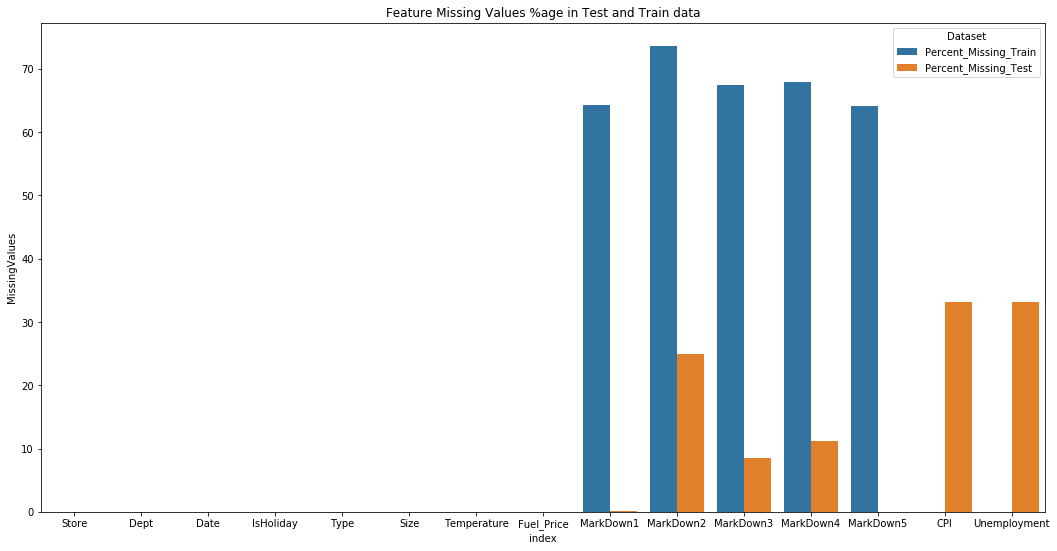

In [171]:
fig = plt.figure(figsize=(18,9))
sns.barplot(data=md,x='index',y='MissingValues',hue='Dataset').set_title('Feature Missing Values %age in Test and Train data')

Only markdown columns have missing values in the train data for the MarkDown columns. However, the test data contains missing values for some Markdown columns and a significant amount in the CPI and Unemployment columns.  

In [172]:
train_ts_data = train_data.set_index('Date')

In [173]:
def perc_missing(series):
    return sum(series)*100/len(series)

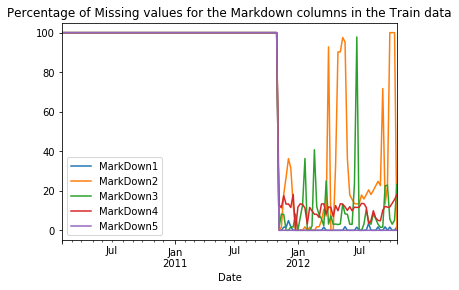

In [174]:
train_ts_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Train data')

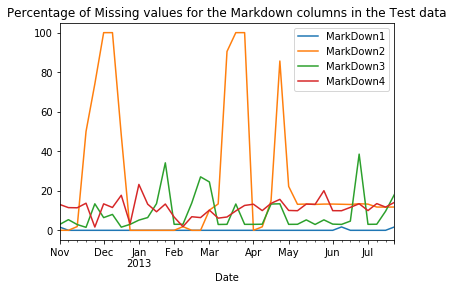

In [175]:
test_ts_data = test_data.set_index('Date')
test_ts_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Test data')

The above graphs depict that all values for the Markdown columns are missing before Nov-11 while some are missing in the train data after that as well.

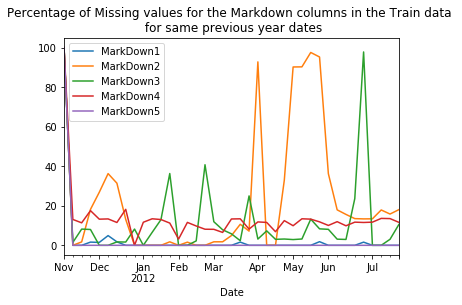

In [176]:
train_ts_data.loc['Nov-2011':'Jul-2012',['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Train data \n for same previous year dates')

Graphs: 
1. Missing values of Markdown columns in the test data for year 2013
2. Missing values of Markdown columns in the train data for year 2012
        
Analysizing the missing values for the whole time period we see a similar trend in the missing values, particularly in Markdown1 and Markdown 3. Markdown 4 seems consistentintly random across the time period. 

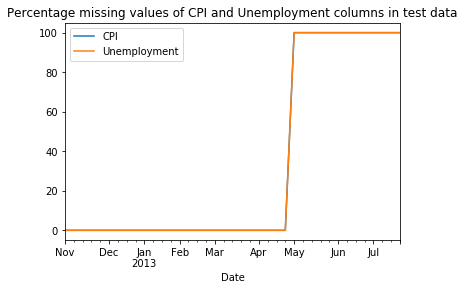

In [177]:
test_ts_data[['CPI','Unemployment']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title = 'Percentage missing values of CPI and Unemployment columns in test data')

The missing values in the CPI and Unemployment columns appear after May only. This can be a potential problem because we will not have this information available when making predictions.

## Analysis of Weekly_sales relationships with other features

Text(0.5, 1.0, 'Type wise Weekly Sales over time in Train Data')

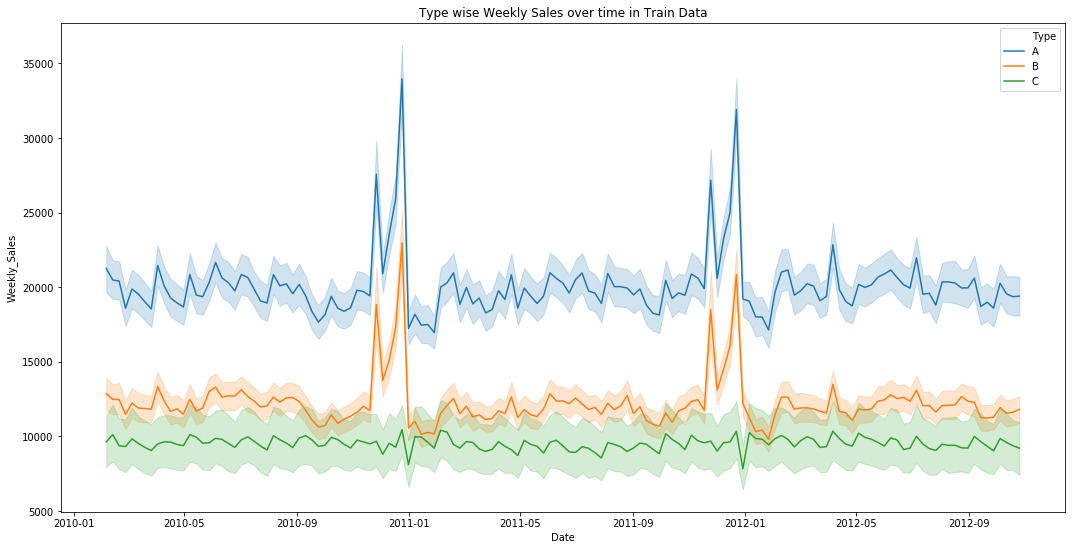

In [181]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Weekly_Sales',hue='Type',data = train_data).set_title('Type wise Weekly Sales over time in Train Data')

Type is an important variable - We can see that the weekly sales are clearly distinguishable between each Type of Store

Text(0.5, 1.0, 'Density plot for the feature CPI')

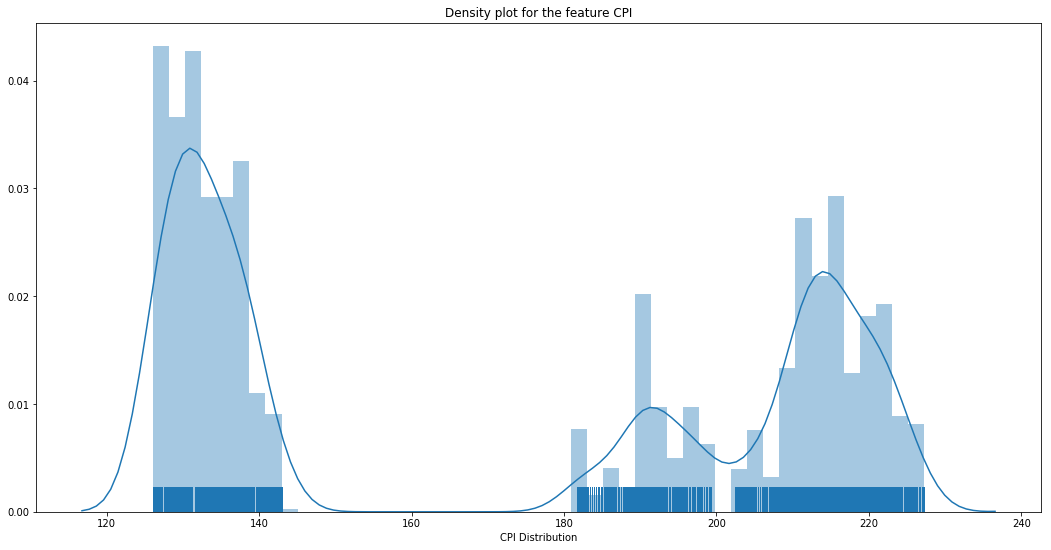

In [182]:
fig = plt.figure(figsize=(18,9))
sns.distplot(a=train_ts_data['CPI'],axlabel='CPI Distribution',rug=True).set_title('Density plot for the feature CPI')

We can see a trimodal distribution of the CPI values. Lets try to convet these into ordinal values i.e. LowCPI,MedCPI and HighCPU and then analyze their relationship with the weekly sales.

In [183]:
train_data['CPI_cat'] = np.where(train_ts_data.CPI<160,'LowCPI',np.where(train_ts_data.CPI<200,'MedCPI','HighCPI'))

In [184]:
train_data[(train_data.CPI_cat == 'HighCPI')].CPI.describe()

count    154507.000000
mean        215.462652
std           5.570376
min         202.370509
25%         211.295141
50%         214.925487
75%         220.065199
max         227.232807
Name: CPI, dtype: float64

Text(0.5, 1.0, 'Weekly_Sales VS Date - Split over CPI Categories')

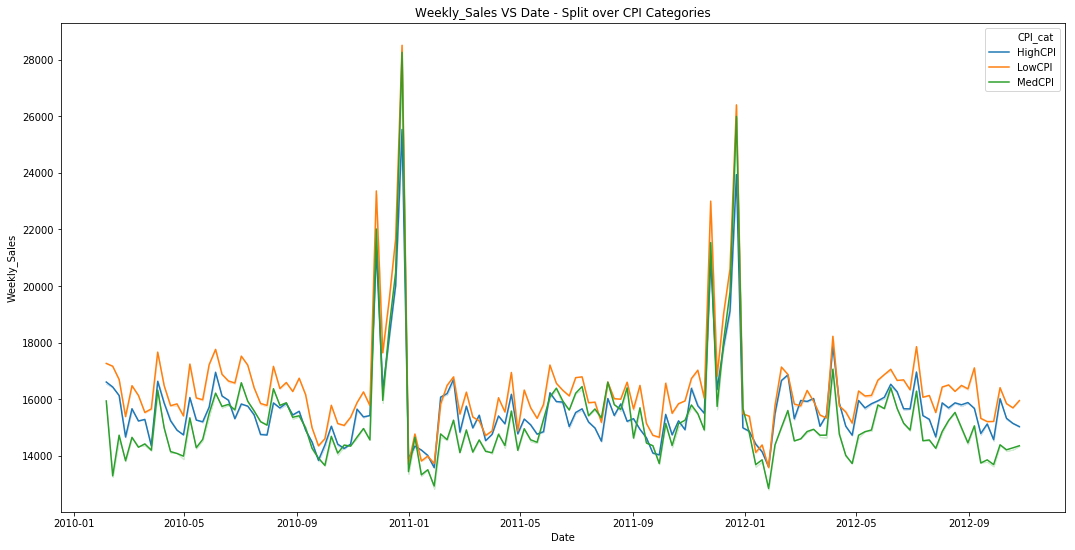

In [185]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 3 CPI Categories')

We can see that for LowCPI weekly sales are consistently higher than both Med and High. Howerver the difference between Med and High isnt quite noticeble. Lets try this again with two categories of CPI only i.e. LowCPI and HighCPI 

In [186]:
train_data['CPI_cat'] = np.where(train_ts_data.CPI<160,'LowCPI','HighCPI')

Text(0.5, 1.0, 'Weekly_Sales VS Date - Split over 2 CPI Categories')

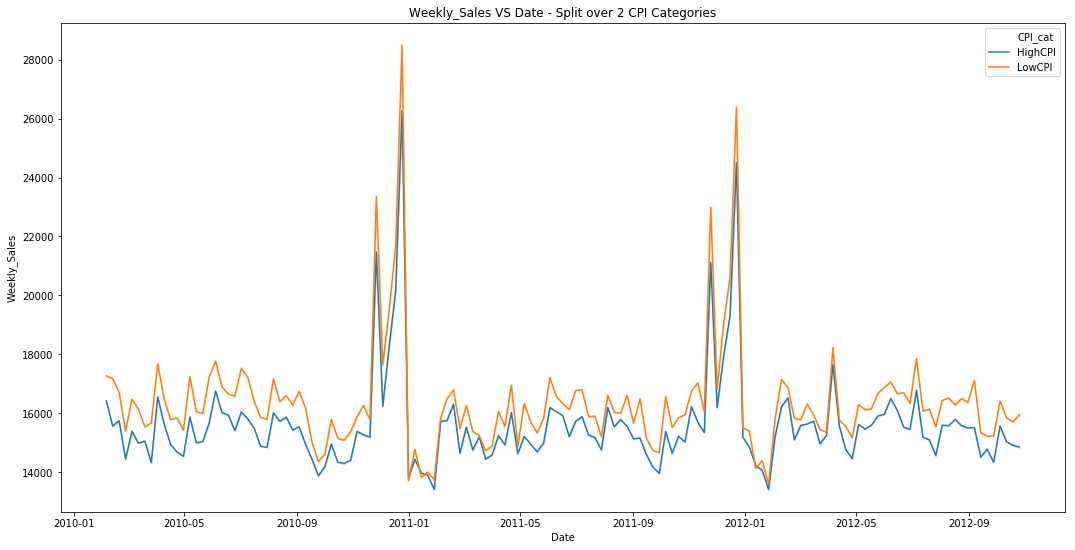

In [187]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 2 CPI Categories')

Text(0.5, 1.0, 'CPI over time')

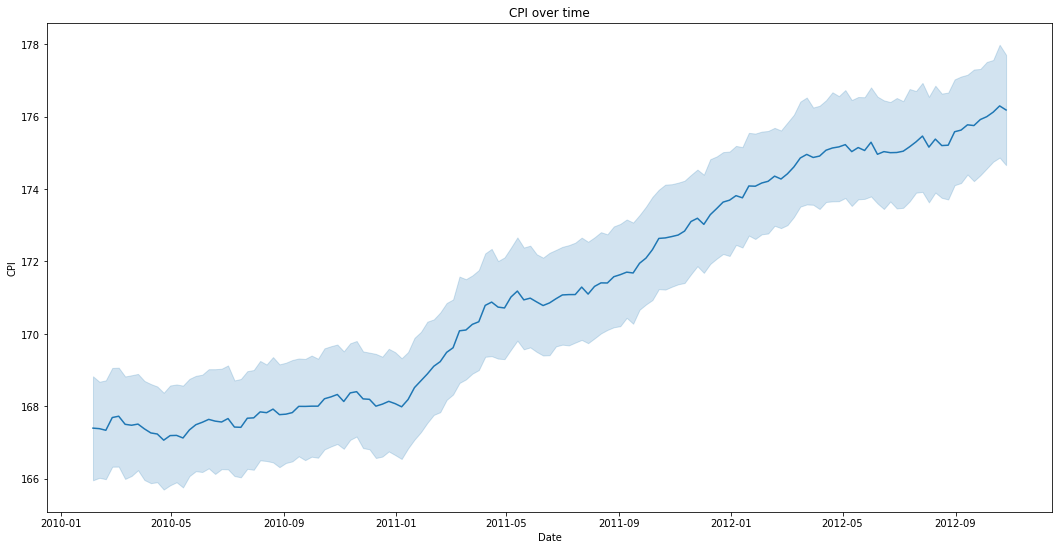

In [188]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='CPI',data = train_data).set_title('CPI over time')

The CPI itself has an increasing trend over time. What would that imply? It also directs us to the question as to how are these populated?

Text(0.5, 1.0, 'Unemployment over time')

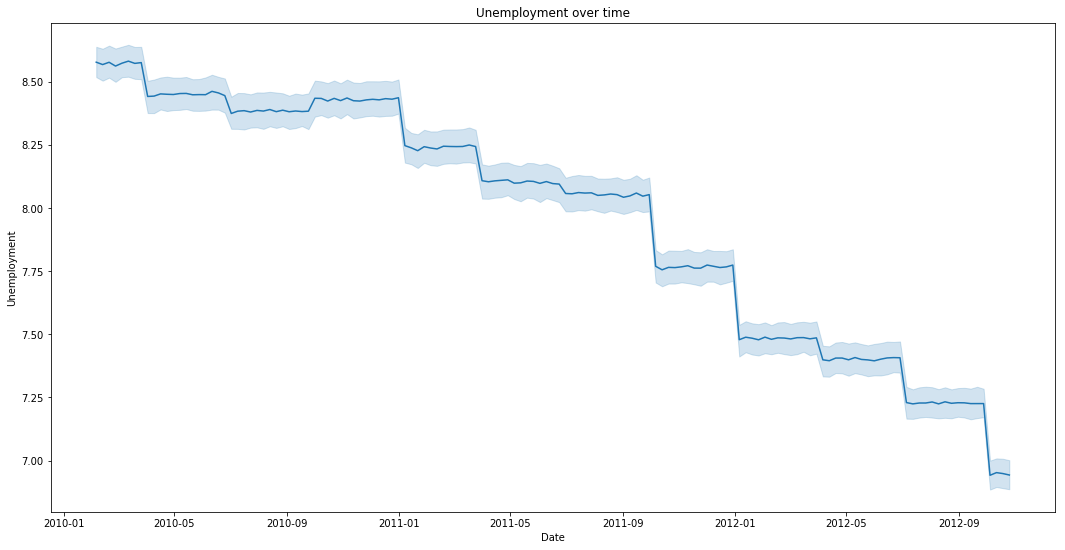

In [189]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Unemployment',data = train_data).set_title('Unemployment over time')

Unemployment has a decreasing trend over time as well. Lets explore store wise CPI and Unemployment rates.

Text(0.5, 1.0, 'Store wise uemployment over time')

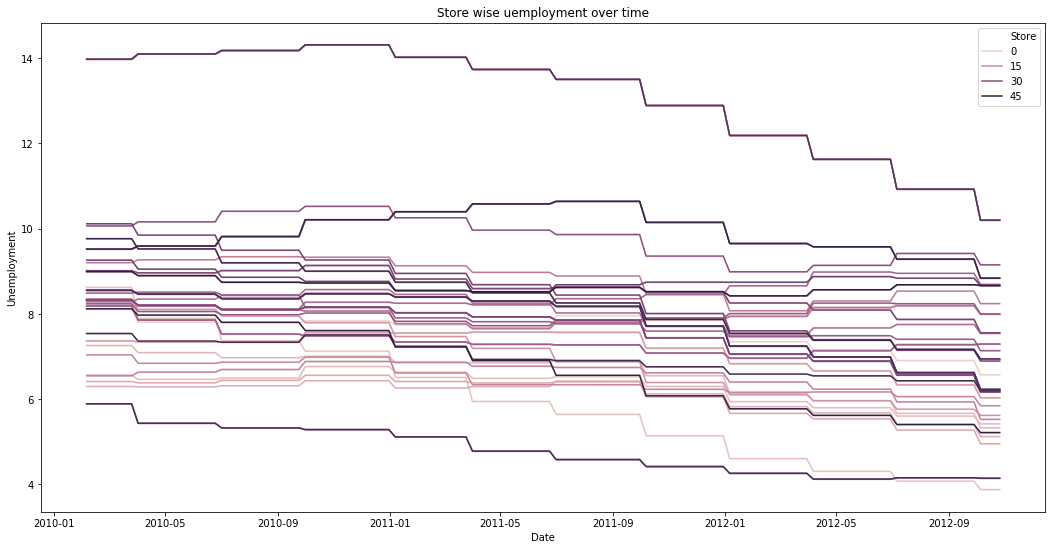

In [190]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Unemployment',hue='Store',data = train_data).set_title('Store wise uemployment over time')

Text(0.5, 1.0, 'Store wise CPI over time')

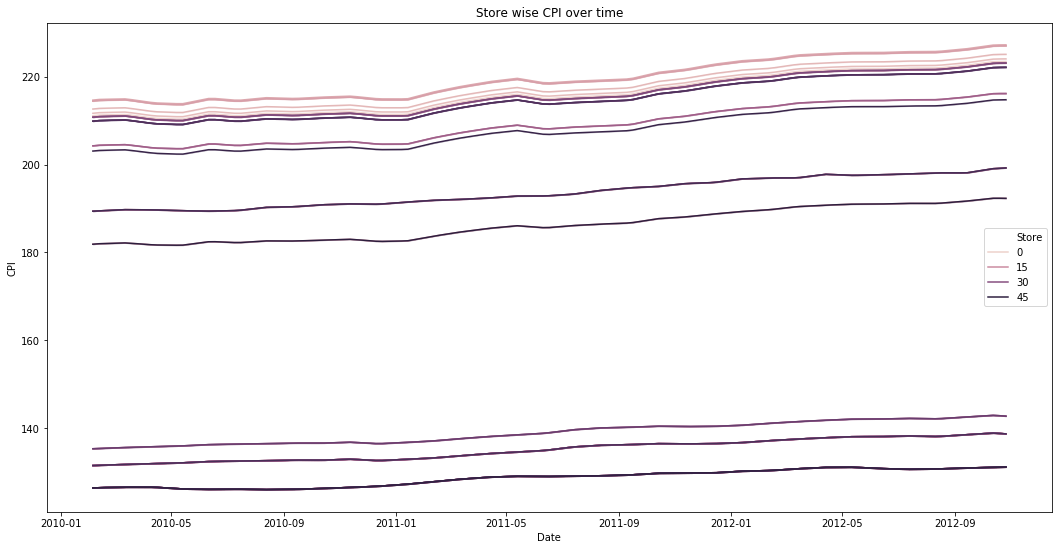

In [191]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='CPI',hue='Store',data = train_data).set_title('Store wise CPI over time')

We see that generally the overall trends for CPI and unemployement are consistent with the individual stores trends

Text(0.5, 1.0, 'CPI trend for the 2 new categories i.e. HighCPI and LowCPI')

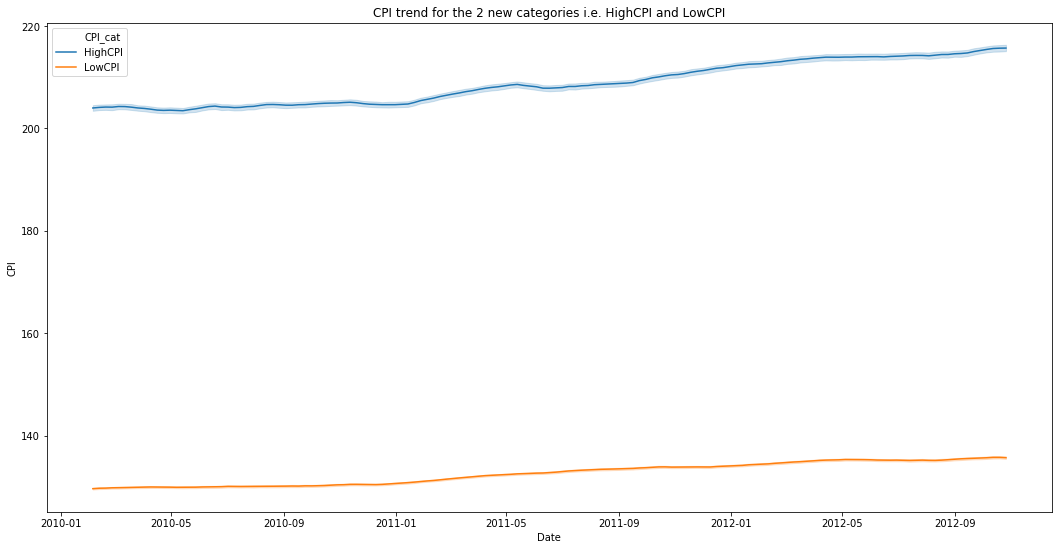

In [192]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='CPI',hue='CPI_cat',data = train_data).set_title('CPI trend for the 2 new categories i.e. HighCPI and LowCPI')

Same is true for high and low CPI categories

Does size remain constant for all stores?

Text(0.5, 1.0, 'Store wise Size over time')

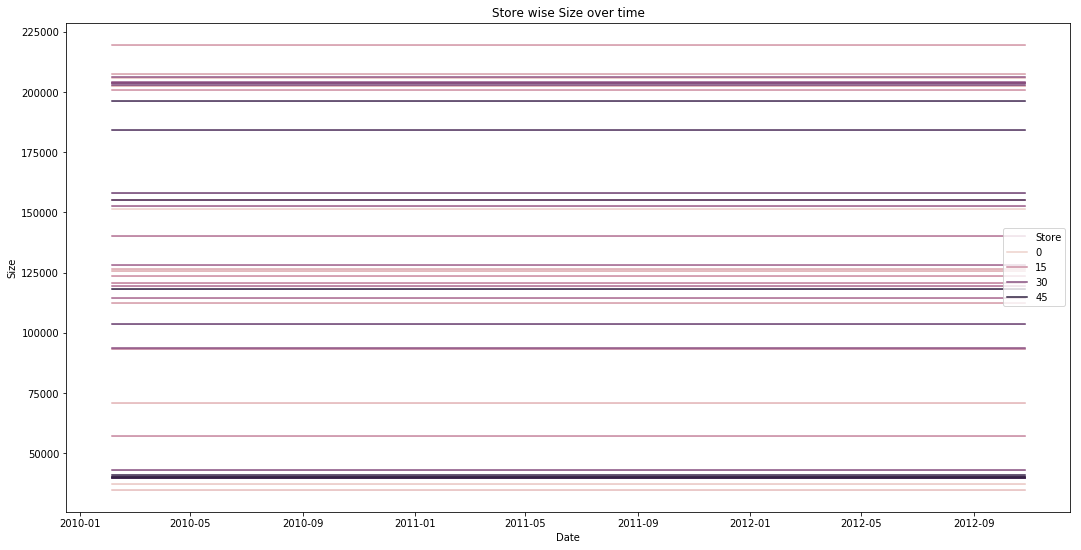

In [193]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Size',hue='Store',data = train_data).set_title('Store wise Size over time')

Straight lines indicate that the size remains constant for each store

Text(0.5, 1.0, 'Density plot for the Store Sizes')

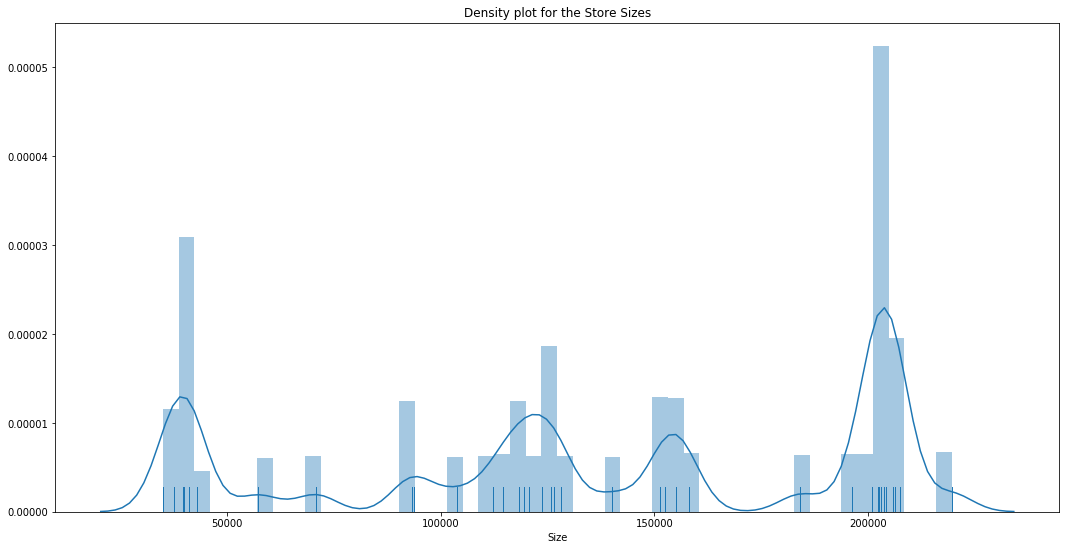

In [194]:
fig = plt.figure(figsize=(18,9))
sns.distplot(a=train_data.Size,rug=True).set_title('Density plot for the Store Sizes')

We can see 3 categories of sizes i.e. Small, Medium and Large

In [195]:
train_data['Size_cat'] = np.where(train_ts_data.Size<75000,'Small_Size',np.where(train_ts_data.Size<175000,'Mid_Size','High_Size'))

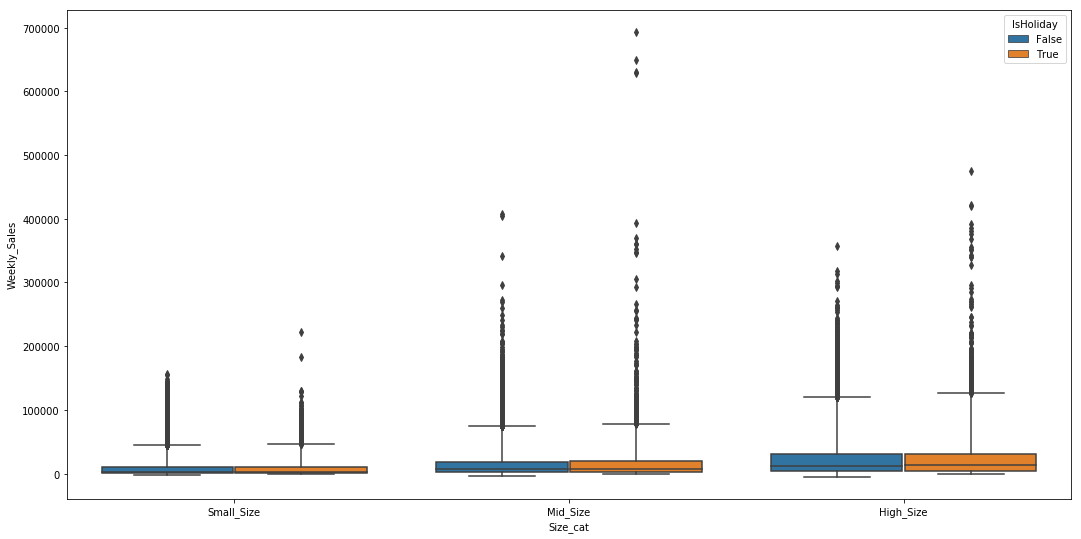

In [199]:
fig = plt.figure(figsize=(18,9))
sns.boxplot(y='Weekly_Sales',x='Size_cat',hue='IsHoliday',data=train_data,whis=3.5,order=['Small_Size','Mid_Size','High_Size'])

An interesting observation here is that some of the Mid_Size store perform just as good or sometime even better than the High_Size stores. Maybe normalizing WeeklySales over size could be experimented.

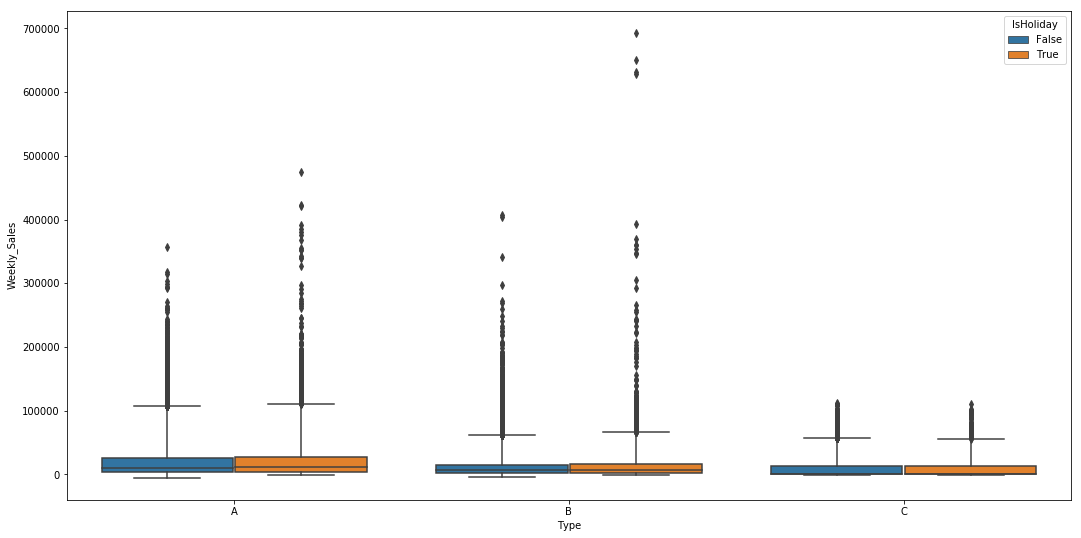

In [131]:
fig = plt.figure(figsize=(18,9))
sns.boxplot(y='Weekly_Sales',x='Type',hue='IsHoliday',data=train_data,whis=3.5)

We see that the weekly_sales have a lot of outliers even if the outlier threshold is set at 3.5 standard deviations. They are present for both Holiday and NonHoliday days.

Lets look at the distribution of Weekly_Sales.

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

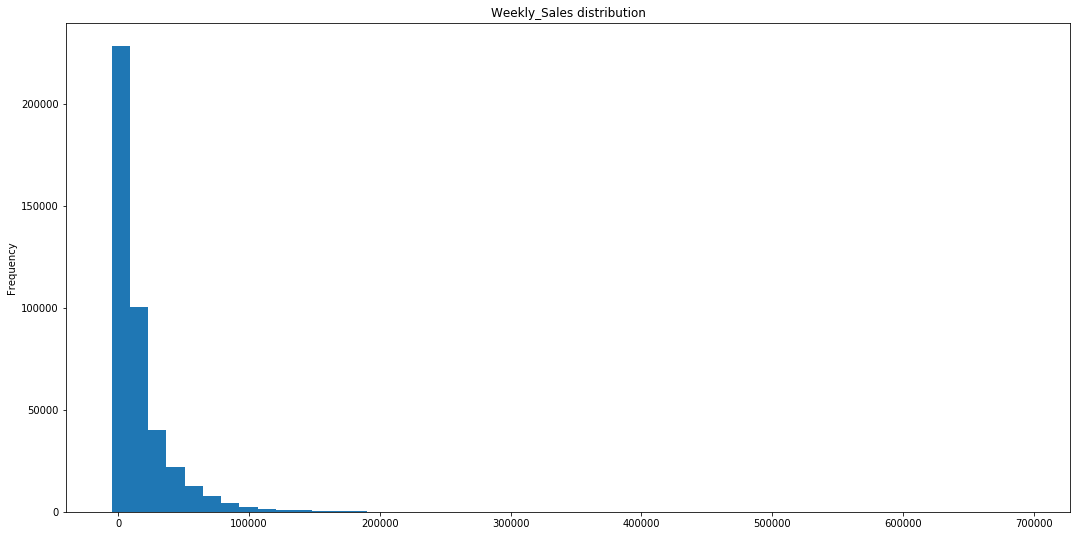

In [200]:
fig = plt.figure(figsize=(18,9))
train_data.Weekly_Sales.plot.hist(bins=50,title='Weekly_Sales distribution')
train_data.Weekly_Sales.describe()

In [201]:
negative_vals_perc = round(sum(train_data.Weekly_Sales<0)*100/len(train_data),3)
negative_vals_perc

0.305

We can see that the distribution of sales is very skewed to the right. Transforming the values to the logarithmic scale can be tried. Before that the negative values have to be removed from the dataset. This can be done safely since they are 0.305% of the total rows in the dataset.

# Cleaning data

In [202]:
train_log = train_data[train_data.Weekly_Sales>0]

In [203]:
train_log['Weekly_Sales_log'] = np.log(train_clean.Weekly_Sales)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
train_log.head()

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1 2010-02-05      24924.50      False    A  151315        42.31   
1      1     1 2010-02-12      46039.49       True    A  151315        38.51   
2      1     1 2010-02-19      41595.55      False    A  151315        39.93   
3      1     1 2010-02-26      19403.54      False    A  151315        46.63   
4      1     1 2010-03-05      21827.90      False    A  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  CPI_cat  Size_cat  Weekly_Sales_log  
0  211.096358         8.106  HighCPI  Mid_Size         10.123607  
1  211.242170         8.106  HighCPI  Mid_Size         10.737255  
2  211.289143         8.106  HighCPI  Mid_Size         10.635748  
3  211.319643         8.106  HighCPI  Mid_Size          9.873211  
4  211.350143         8.106  HighCPI  Mid_Size          9.990944

count    420212.000000
mean          8.520815
std           2.049011
min          -4.605170
25%           7.659233
50%           8.943989
75%           9.916960
max          13.448929
Name: Weekly_Sales_log, dtype: float64

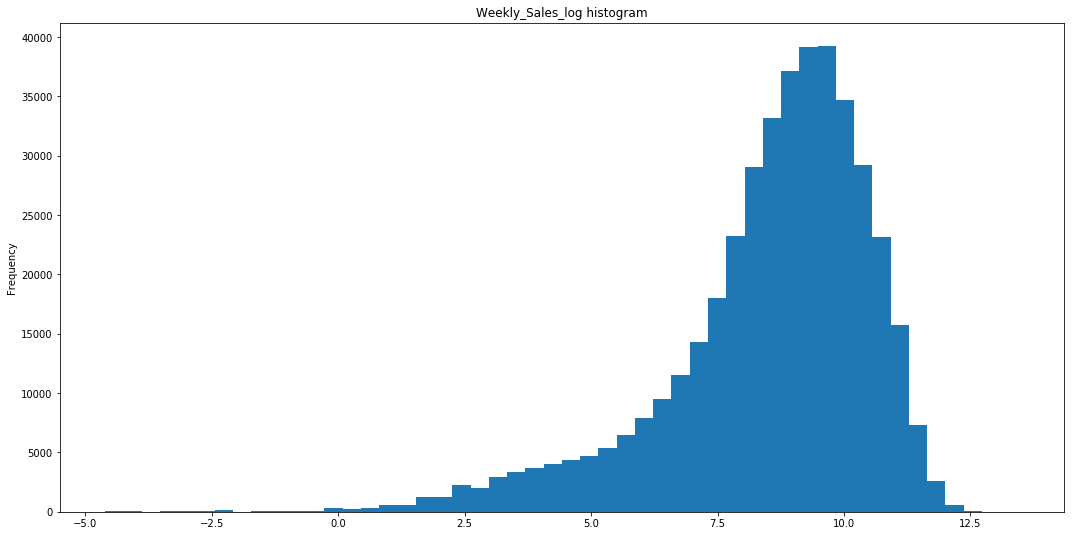

In [207]:
fig = plt.figure(figsize=(18,9))
train_log.Weekly_Sales_log.plot.hist(bins=50,title='Weekly_Sales_log histogram')
train_log.Weekly_Sales_log.describe()

This seems like a better distribution to work with. Lets investigate the relationships of these with the rest of the features again.

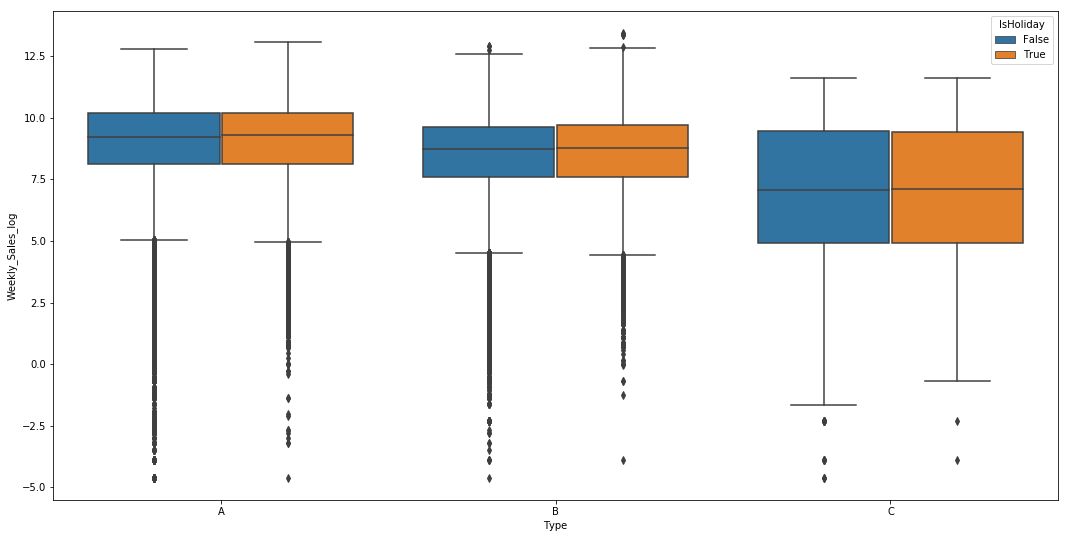

In [206]:
fig = plt.figure(figsize=(18,9))
sns.boxplot(y='Weekly_Sales_log',x='Type',hue='IsHoliday',data=train_log)

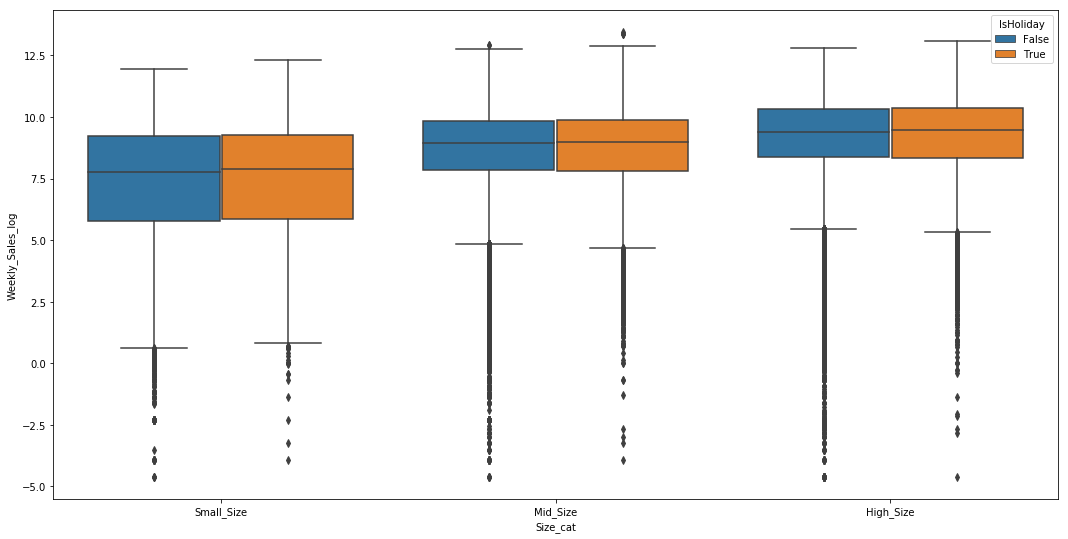

In [135]:
fig = plt.figure(figsize=(18,9))
sns.boxplot(y='Weekly_Sales_log',x='Size_cat',hue='IsHoliday',data=train_log,order=['Small_Size','Mid_Size','High_Size'])

Text(0.5, 1.0, 'Weekly sales log over time split by Type')

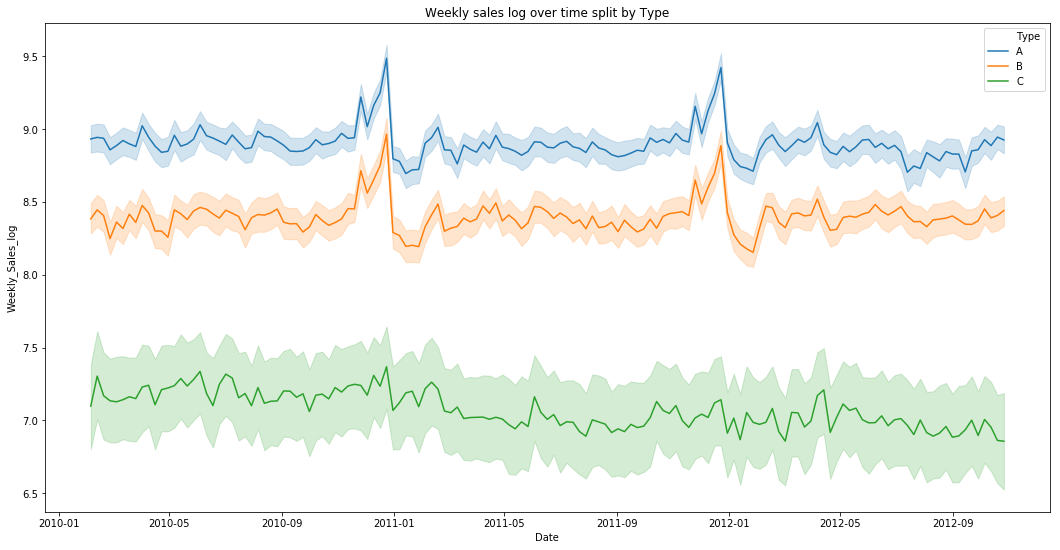

In [209]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Weekly_Sales_log',hue='Type',data = train_log).set_title('Weekly sales log over time split by Type')

Text(0.5, 1.0, 'Weekly sales log over time split by CPI_cat ')

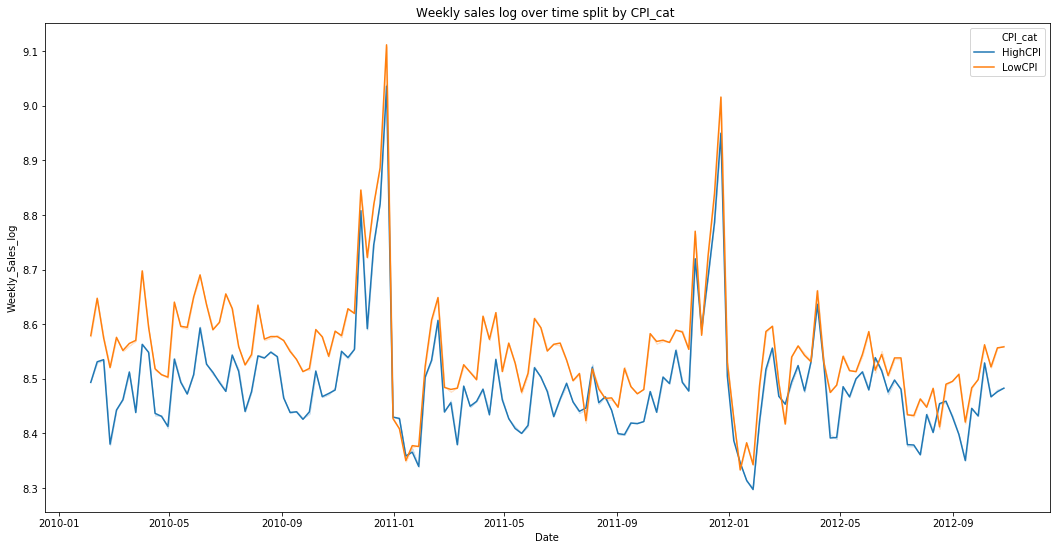

In [210]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(x='Date',y='Weekly_Sales_log',hue='CPI_cat',data = train_log,ci=False).set_title('Weekly sales log over time split by CPI_cat ')

<Figure size 1296x648 with 0 Axes>

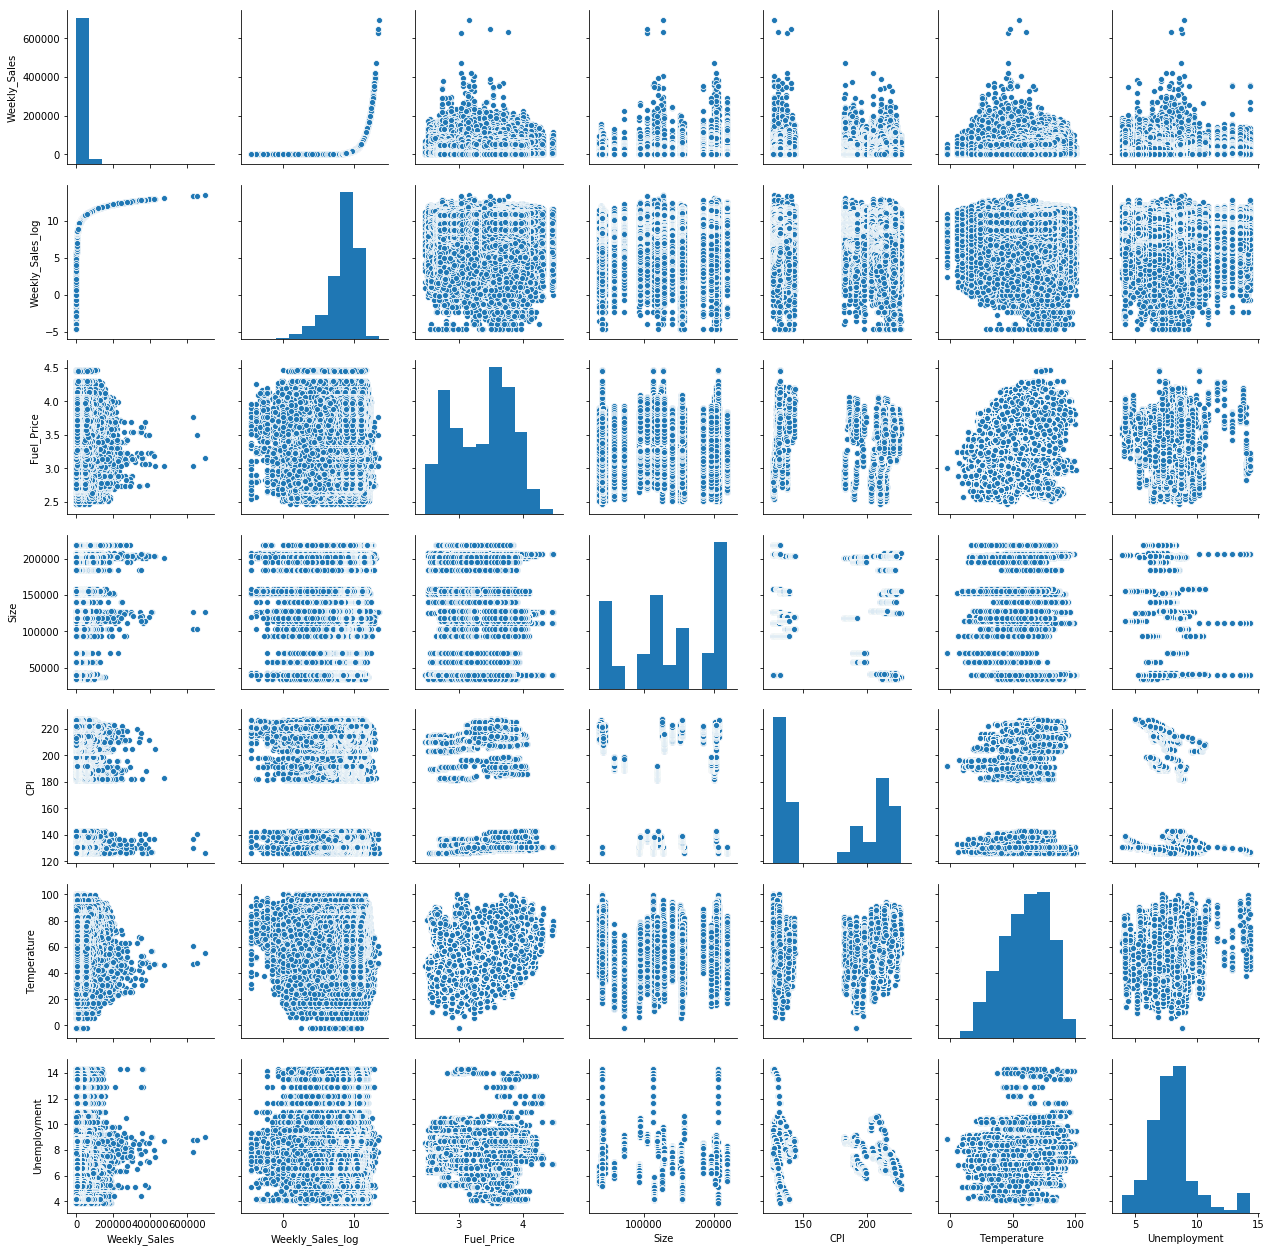

In [120]:
fig = plt.figure(figsize=(18,9))
g = sns.pairplot(train_log,vars=['Weekly_Sales','Weekly_Sales_log', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'])

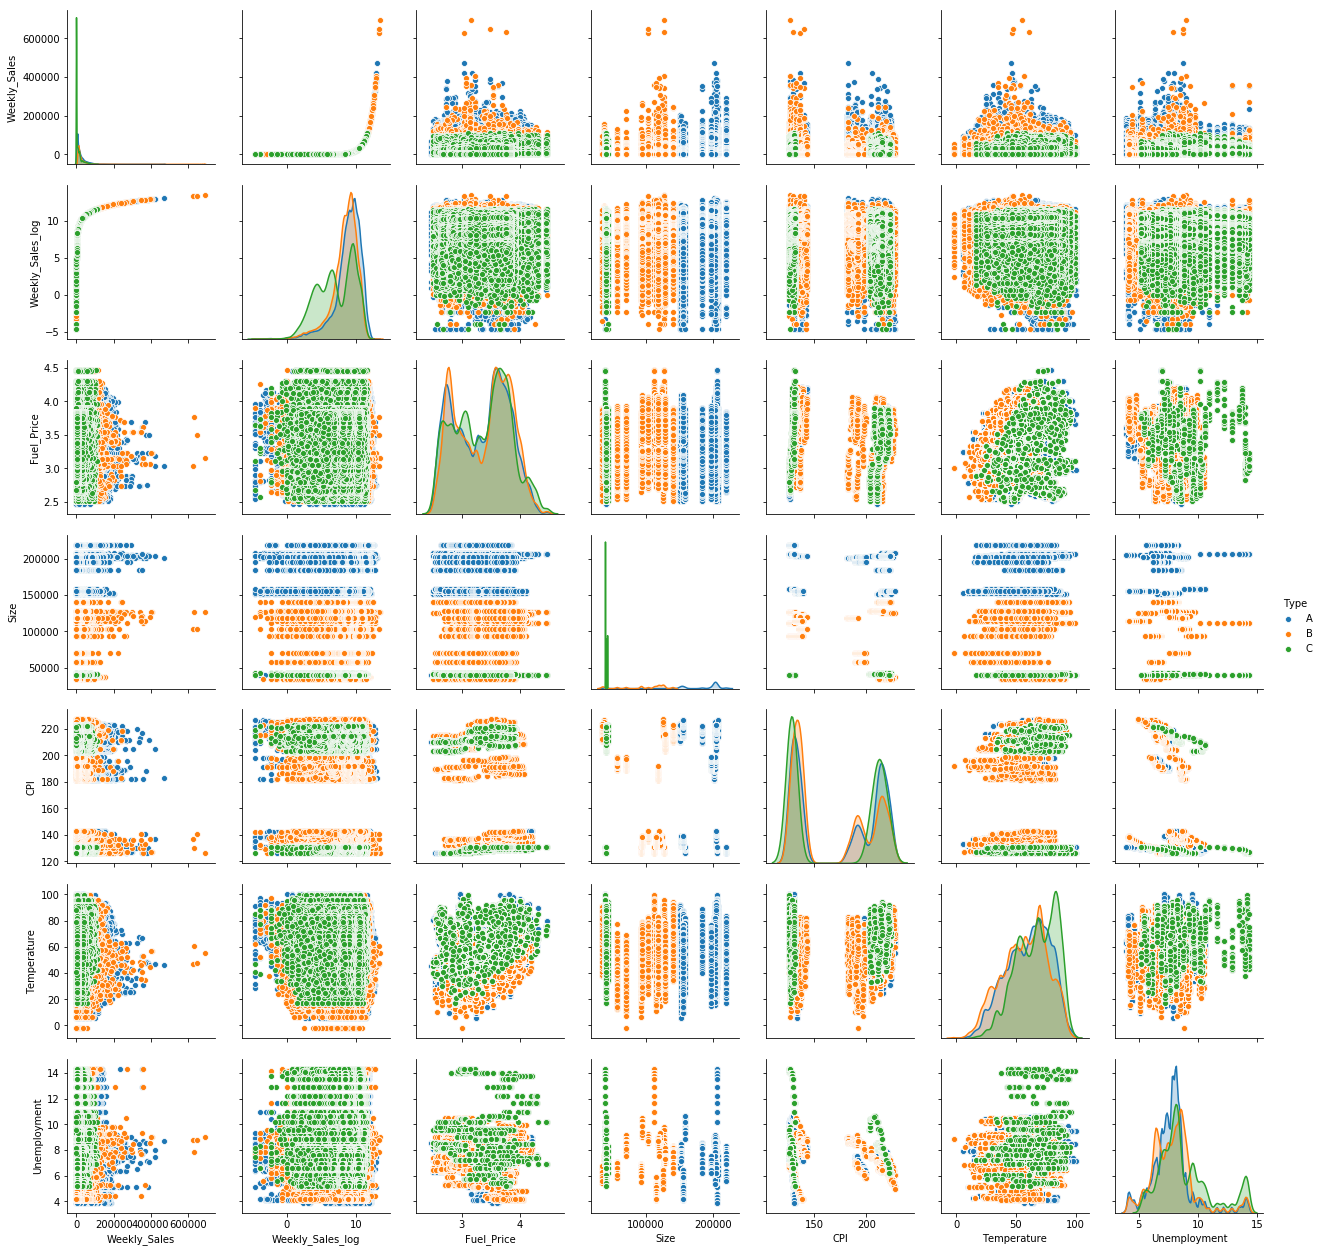

In [121]:
g = sns.pairplot(train_log,vars=['Weekly_Sales','Weekly_Sales_log', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'Type')

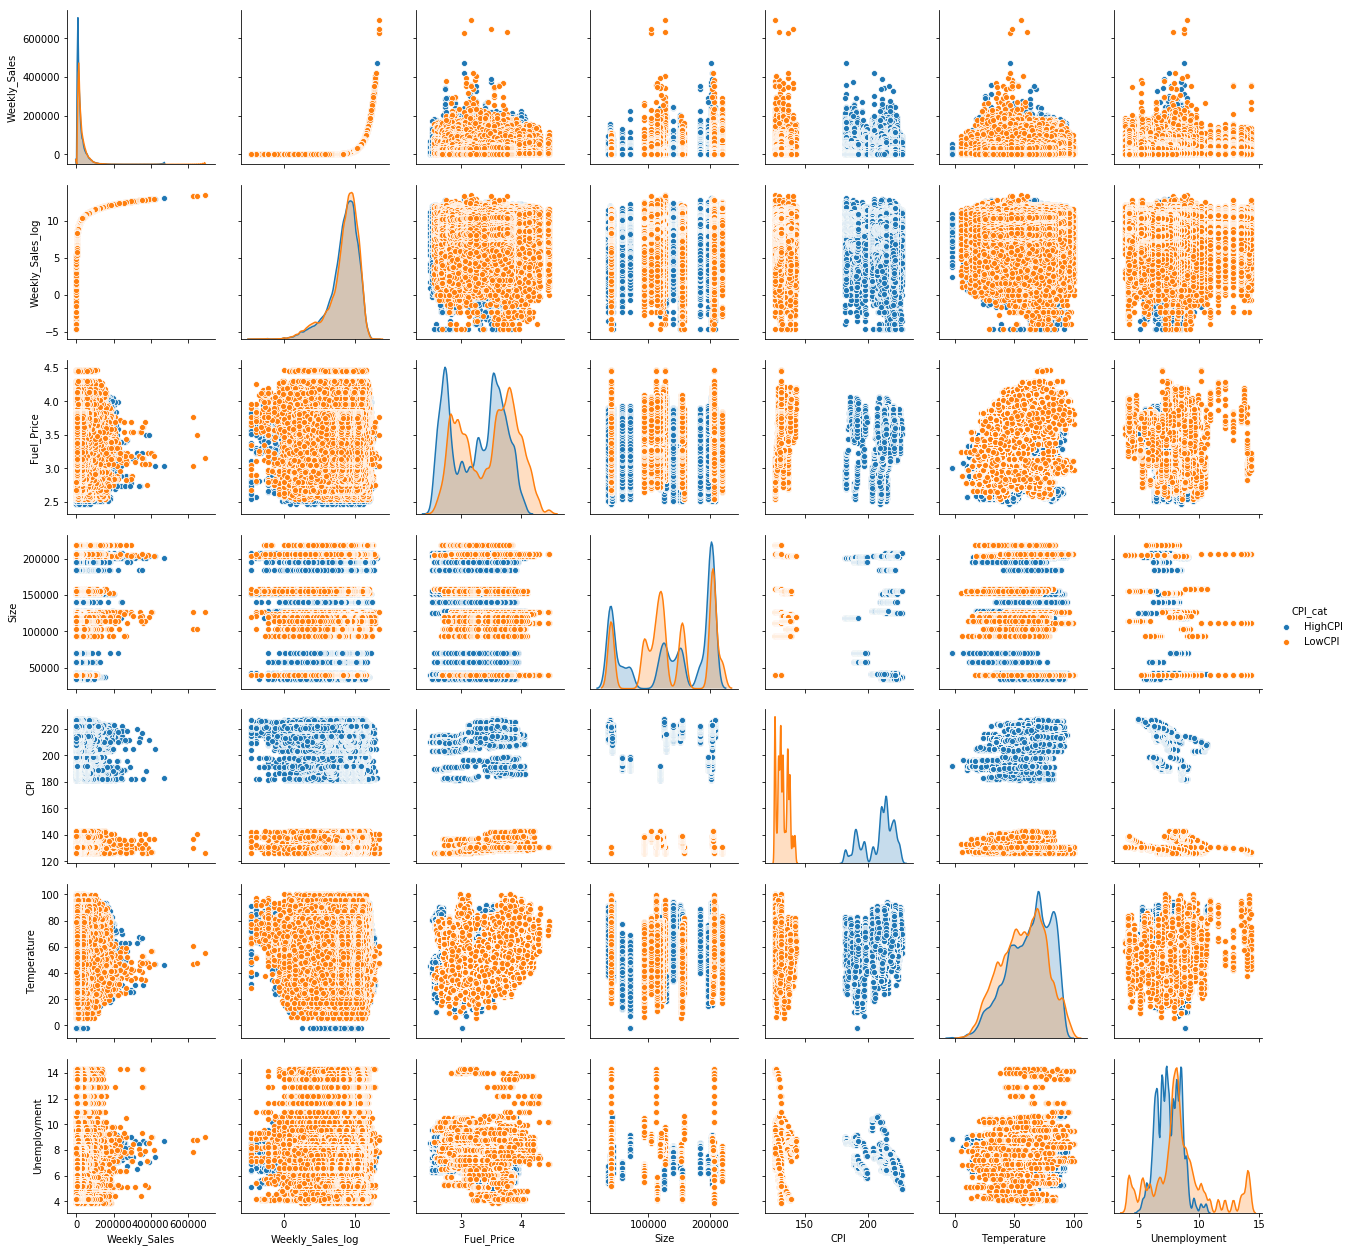

In [122]:
g = sns.pairplot(train_log,vars=['Weekly_Sales','Weekly_Sales_log', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'CPI_cat')

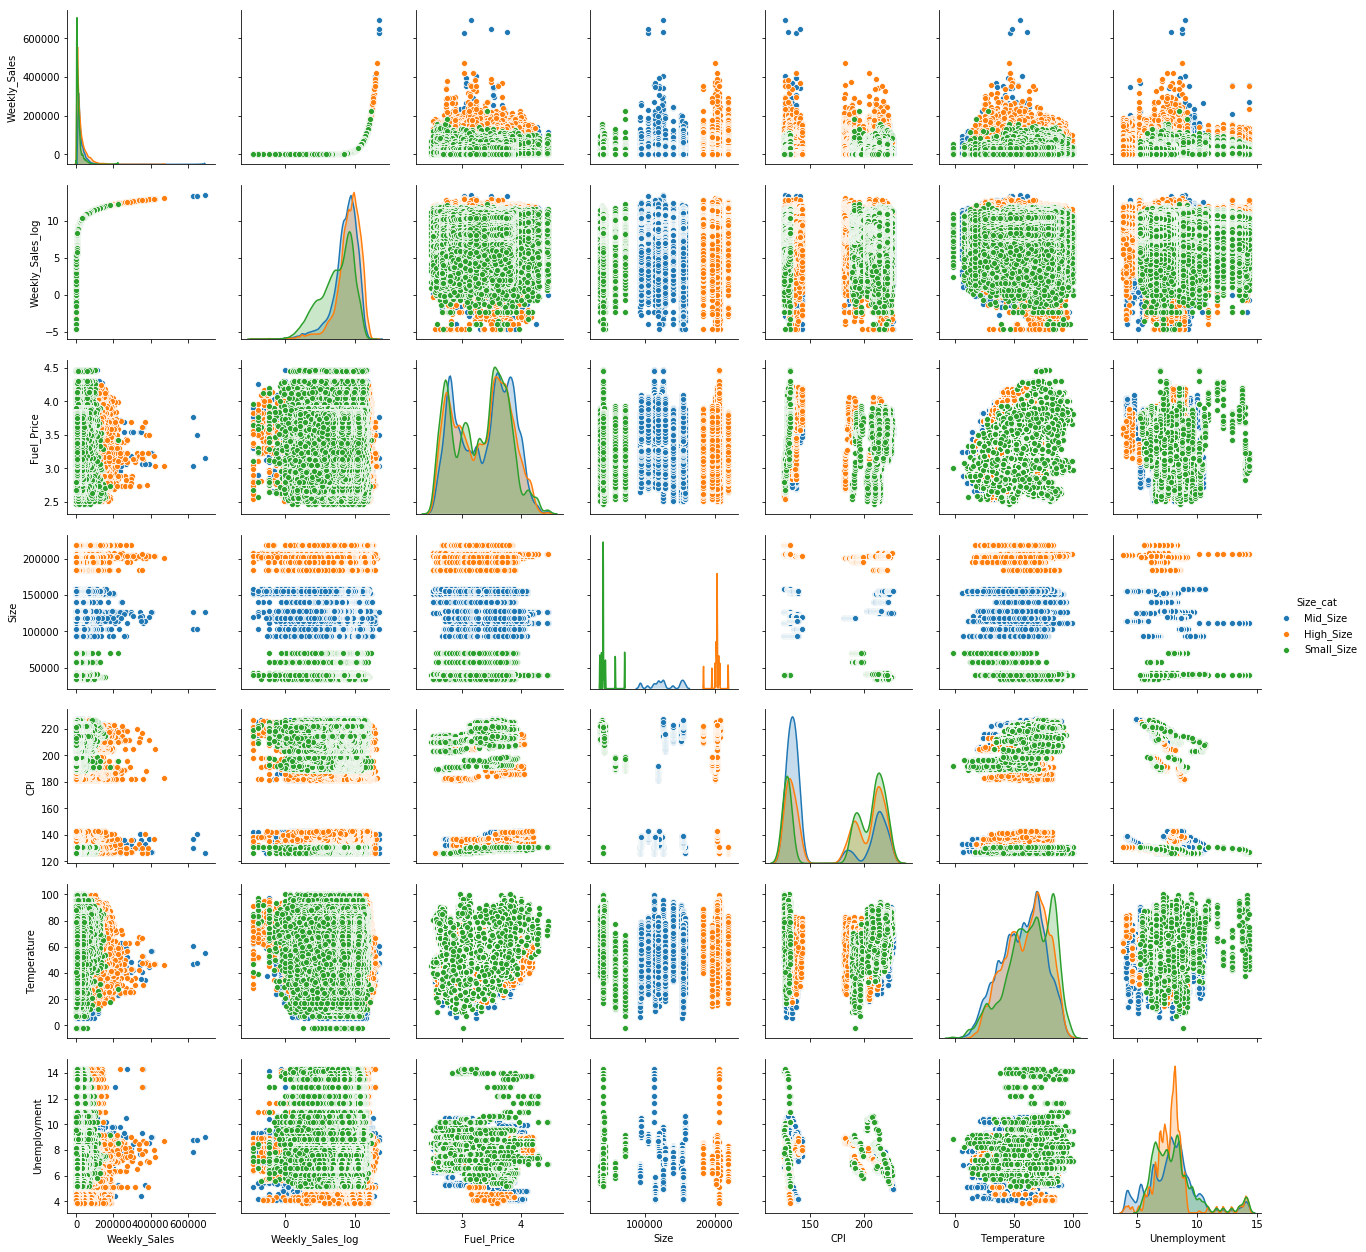

In [123]:
g = sns.pairplot(train_log,vars=['Weekly_Sales','Weekly_Sales_log', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'Size_cat')

# Conclusion

From the analysis we can conclude the following:
1. Weekly Sales should be transformed to the logrithmic scale so that the distribution isnt as skewed
2. The variables Size, CPI and Type are good distinguishers of WeeklySales data
3. Some mechanism needs to be developed to cater for the missing data, particularly in the MarkdownColumns
4. Weekly sales Outliers problem is somewhat sorted by transforming to the logarithmic scale, however, there might still be need to look into outliers that appear the scale change. This can be done in the modeling process 
5. Some more features can also be engineered however their effectiveness can only be judged when making predictions.